In [1]:
using Plots
using LaTeXStrings
using DifferentialEquations
using LinearAlgebra
using PrettyTables

### 1. Introduction
We first introduce the shorthand notation
$$
f_i = f(t_i,u_i).
$$
A $k$-step multistep(or linear multistep) method is given by the difference equation
$$
 \begin{split}u_{i+1} &= a_{k-1}u_i + \cdots + a_0 u_{i-k+1} \qquad \\ 
& \qquad + h ( b_kf_{i+1} + \cdots + b_0 f_{i-k+1}),\end{split}
$$
where the $a_j$ and the $b_j$ are constants. If $b_k = 0$, the method is explicit; otherwise it is implicit.

The value $u_0$ is  determined by the initial condition, but we also need some way of generating the starting values
$$
u_1 = \alpha_1, \cdots, u_{k-1} = \alpha_{k-1}.
$$
In practice, the starting values are often found using an RK formula.

### 2. Explicit method
#### 2.1 Numerical scheme of AB4
An explicit method named 4th-order Adams–Bashforth(AB4) is introduced in this section, whose numerical scheme is
$$
u_{i+1} = u_i + h\, ( \tfrac{55}{24}f_i - \tfrac{59}{24} f_{i-1} + \tfrac{37}{24}f_{i-2} - \tfrac{9}{24}f_{i-3}), \quad i=3,\ldots,n-1.
$$
As we mentioned above, the starting values $u_1, u_2, u_3$ can be computed by 4th order Runge-Kutta method. we further give a implementation of AB4 as follows

#### 2.2 Implementation

In [2]:
# Implementation of the 4th order Runge-Kutta
# Copied from https://tobydriscoll.net/fnc-julia/ivp/rk.html
"""
    rk4(ivp,n)

Apply the common Runge-Kutta 4th order method to solve the given 
IVP using `n` time steps. Returns a vector of times and a vector of
solution values.
"""
function rk4(ivp, n)
    # Time discretization
    a, b = ivp.tspan
    h = (b-a)/n
    t = [a + i*h for i in 0:n]

    # Initialize output
    u = fill(float(ivp.u0), n+1)

    # Time stepping
    # Time stepping.
    for i in 1:n
        k₁ = h*ivp.f( u[i],      ivp.p, t[i]     )
        k₂ = h*ivp.f( u[i]+k₁/2, ivp.p, t[i]+h/2 )
        k₃ = h*ivp.f( u[i]+k₂/2, ivp.p, t[i]+h/2 )
        k₄ = h*ivp.f( u[i]+k₃,   ivp.p, t[i]+h   )
        u[i+1] = u[i] + (k₁ + 2(k₂+k₃) + k₄)/6
    end
    return t,u
end

rk4

In [3]:
# copied from https://tobydriscoll.net/fnc-julia/ivp/implicit.html
 """
     ab4(ivp,n)
 
 Apply the Adams-Bashforth 4th order method to solve the given IVP
 using `n` time steps. Returns a vector of times and a vector of
 solution values.
 """
 function ab4(ivp, n) 
     # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Constants in the AB4 method.
    k = 4;   σ = [55,-59,37,-9]/24;

    # Find starting values by RK4.
    u = fill(float(ivp.u0),n+1)
    rkivp = ODEProblem(ivp.f,ivp.u0,(a,a+(k-1)*h),ivp.p)
    ts,us = rk4(rkivp,k-1)
    u[1:k] .= us

    # Compute history of f' values, from newest to oldest.
    f = [ ivp.f(u[k-i],ivp.p,t[k-i]) for i in 1:k-1  ]

    # Time stepping.
    for i in k:n
        f = [ ivp.f(u[i],ivp.p,t[i]), f[1:k-1]... ]   # new value of du/dt
        u[i+1] = u[i] + h*sum(f[j]*σ[j] for j in 1:k)  # advance a step
    end
    return t,u
end

ab4

#### 2.3 Examples
We study the convergence of AB4 using the IVP $u'=\sin[(u+t)^2]$ over $0 \leq t \leq 4$, with $u(0)  = - 1$. As usual, `solve` is called to give an accurate reference solution.

In [4]:
ivp = ODEProblem((u,p,t)->sin((t+u)^2),-1.,(0.0,4.0))
u_ref = solve(ivp,Tsit5(),reltol=1e-14,abstol=1e-14);

In [5]:
n = @. [ round(Int,4*10^k) for k in 0:0.5:3 ]
err = []
for n in n
    t,u = ab4(ivp,n)
    push!( err, norm(u_ref.(t)-u,Inf) )
end

pretty_table([n err]; header=["n","inf-norm error"])

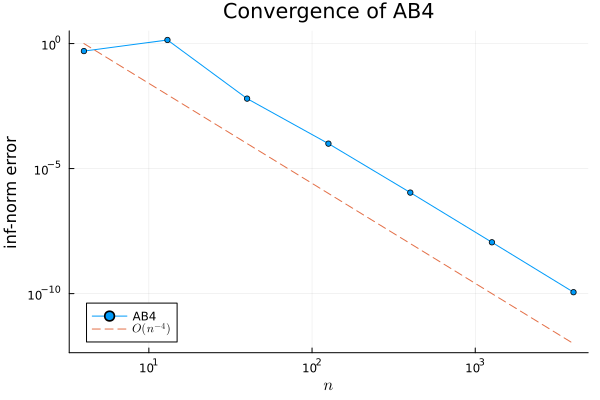

In [6]:
plot(n,err,m=3,label="AB4",
    xaxis=(:log10,L"n"),yaxis=(:log10,"inf-norm error"),
    title="Convergence of AB4",leg=:bottomleft)

plot!(n,(n/n[1]).^(-4),l=:dash,label=L"O(n^{-4})")

### 3. Implicit method
#### 3.1 Numerical scheme of AM2
An implicit method name second-order Adams–Moulton method is introduced in this section, whose numerical scheme is
$$
u_{i+1} = u_{i} + \frac{1}{2} f(t_i, u_i) + \frac{1}{2} f(t_{i+1}, u_{i+1}).
$$
To advance from step $i$ to $i+1$, we need to solve
$$
z - \frac{1}{2} h f(t_{i+1}, z) = u_i + \frac{1}{2} h f(t_i, u_i)
$$
for $z$. This equation can be written as $g(z) = 0$. An implementation of AM2 is as follows
#### 3.2 Implementation

In [19]:
# Finite-difference approximation of a Jacobian
# Copied from https://tobydriscoll.net/fnc-julia/nonlineqn/quasinewton.html#function-levenberg

"""
    fdjac(f,x₀[,y₀])

Compute a finite-difference approximation of the Jacobian matrix for
`f` at `x₀`, where `y₀`=`f(x₀)` may be given.
"""
function fdjac(f,x₀,y₀=f(x₀))
    δ = sqrt(eps())*max(norm(x₀),1)   # FD step size
    m,n = length(y₀),length(x₀)
    if n==1
        J = (f(x₀+δ) - y₀) / δ
    else
        J = zeros(m,n)
        x = copy(x₀)
        for j in 1:n
            x[j] += δ
            J[:,j] = (f(x) - y₀) / δ
            x[j] -= δ
        end
    end
    return J
end

# Quasi-Newton method for nonlinear systems
# Copied from https://tobydriscoll.net/fnc-julia/nonlineqn/quasinewton.html#function-levenberg
"""
    levenberg(f,x₁[;maxiter,ftol,xtol])

Use Levenberg's quasi-Newton iteration to find a root of the system
`f` starting from `x₁`. Returns the history of root estimates 
as a vector of vectors.

The optional keyword parameters set the maximum number of iterations
and the stopping tolerance for values of `f` and changes in `x`.

"""
function levenberg(f,x₁;maxiter=40,ftol=1e-12,xtol=1e-12)
    x = [float(x₁)]
    yₖ = f(x₁)
    k = 1;  s = Inf;
    A = fdjac(f,x[k],yₖ)   # start with FD Jacobian
    jac_is_new = true

    λ = 10;
    while (norm(s) > xtol) && (norm(yₖ) > ftol)
        # Compute the proposed step.
        B = A'*A + λ*I
        z = A'*yₖ
        s = -(B\z)
        
        x̂ = x[k] + s
        ŷ = f(x̂)

        # Do we accept the result?
        if norm(ŷ) < norm(yₖ)    # accept
            λ = λ/10   # get closer to Newton
            # Broyden update of the Jacobian.
            A += (ŷ-yₖ-A*s)*(s'/(s'*s))
            jac_is_new = false
            
            push!(x,x̂)
            yₖ = ŷ
            k += 1
        else                       # don't accept
            # Get closer to gradient descent.
            λ = 4λ
            # Re-initialize the Jacobian if it's out of date.
            if !jac_is_new
                A = fdjac(f,x[k],yₖ)
                jac_is_new = true
            end
        end

        if k==maxiter
            @warn "Maximum number of iterations reached."
            break
        end
        
    end
    return x
end

# Copied from https://tobydriscoll.net/fnc-julia/ivp/implicit.html
"""
    am2(ivp,n)

Apply the Adams-Moulton 2nd order method to solve given IVP using
`n` time steps. Returns a vector of times and a vector of
solution values.
"""
function am2(ivp, n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initialize output.
    u = fill(float(ivp.u0), n+1)

    # Time stepping.
    for i in 1:n
        # Data that does not depend on the new value.
        known = u[i] + h/2*ivp.f(u[i], ivp.p, t[i])
        # Find a root for the new value.
        g = z -> z - h/2*ivp.f(z, ivp.p, t[i+1]) - known
        unew = levenberg(g, known)
        u[i+1] = unew[end]
    end
    return t, u
end

am2

#### 3.3 Example: Stiff problems
We will introduce an example about stiff problems to show the strength of the implicit method. Considering the IVP $u' = u^2 - u^3$ over $0 \leq t \leq 400$.

In [22]:
ivp = ODEProblem((u,p,t)->u^2-u^3, 0.005, (0,400.))

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 400.0)
u0: 0.005

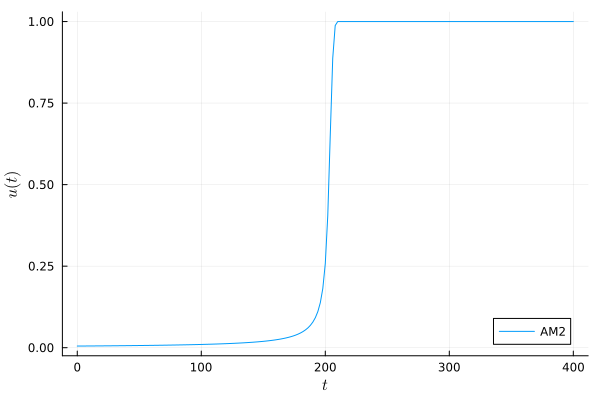

In [23]:
tI, uI = am2(ivp, 200)
plot(tI, uI, label="AM2",
    xlabel=L"t", ylabel=L"u(t)", leg=:bottomright)

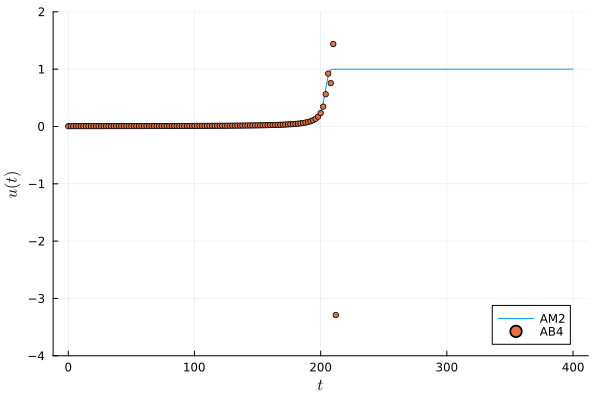

In [24]:
# repeat the process using the explicit AB4 method.
tE,uE = ab4(ivp,200)

scatter!(tE,uE,m=3,label="AB4",ylim=[-4,2])

In [25]:
# Once the solution starts to take off, the AB4 result goes catastrophically wrong.
uE[105:111]

7-element Vector{Float64}:
   0.7553857798343923
   1.4372970308402562
  -3.2889768512289934
 214.1791132643978
  -4.482089146771584e7
   4.1268902909420876e23
  -3.221441244795439e71

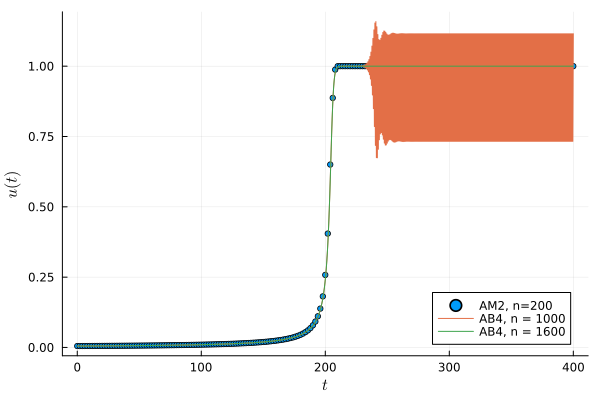

In [28]:
# We hope that AB4 will converge in the limit h -> 0, so let’s try using more steps.
plt = scatter(tI, uI, label="AM2, n=200", m=3,
     xlabel=L"t", ylabel=L"u(t)", leg =:bottomright)

for n in [1000, 1600]
    tE, uE = ab4(ivp, n)
    plot!(tE, uE, label = "AB4, n = $n")
end

plt

So AB4, which is supposed to be more accurate than AM2, actually needs something like 8 times as many steps to get a reasonable-looking answer!